# Harmonic Magnetic Dipole Sounding over a Sphere

In this notebook, we will simulate an FDEM sounding over a conductive sphere. A cylindrical mesh and the [SimPEG](http://simpeg.xyz) Electromanetics module is used to perform the simulation. 

For more on SimPEG and SimPEG.EM see:
- [(Cockett et al., 2015)](http://www.sciencedirect.com/science/article/pii/S009830041530056X): *SimPEG: An open source framework for simulation and gradient based parameter estimation in geophysical applications*
- [(Heagy et al., 2016)](https://arxiv.org/abs/1610.00804): *A framework for simulation and inversion in electromagnetics*

## Setup

An inductive loop transmitter is centered over an electrically conductive sphere (radius 30m). The transmitter is 20m above the surface, and the center of the sphere is 50m below the surface. A coil receiver is offset by 8m horizontally from the transmitter. 

<img src="../../images/cylsetup.png" width=70%>

## Getting Started: Package Imports

- [NumPy](http://www.numpy.org/), [SciPy](https://www.scipy.org/) and [Matplotlib](http://matplotlib.org/) are core Python packages that can be installed when you install python with a distribution such as [Anaconda](https://www.continuum.io/downloads). 

- [SimPEG](http://simpeg.xyz) is a Simulation and Inversion package for geophysics

In [4]:
# Basic python packages
import numpy as np 
import matplotlib.pyplot as plt
from scipy.constants import mu_0

from SimPEG import Mesh, Utils, Maps
from SimPEG.EM import FDEM

# Try importing PardisoSolver from pymatsolver (https://github.com/rowanc1/pymatsolver) 
# otherwise, use SolverLU from SimPEG 
try: 
    from pymatsolver import PardisoSolver as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

# Set a nice colormap! 
plt.set_cmap(plt.get_cmap('viridis'))

%matplotlib inline

## Model Parameters

Resistive halfspace, conductive sphere with a radius of 30m, its center is 50m below the surface. 

In [5]:
sig_halfspace = 1e-6
sig_sphere = 1e0
sig_air = 1e-8

In [6]:
sphere_z = -50.
sphere_radius = 30. 

## Survey Parameters

- Transmitter and receiver 20m above the surface 
- Receiver offset from transmitter by 8m horizontally
- 25 frequencies, logaritmically between $10$ Hz and $10^5$ Hz

In [7]:
boom_height = 20. 
rx_offset = 8. 
freqs = np.logspace(1, 5, 25)

# source and receiver location in 3D space
src_loc = np.r_[0., 0., boom_height]
rx_loc = np.atleast_2d(np.r_[rx_offset, 0., boom_height])

In [8]:
# print the min and max skin depths to make sure mesh is fine enough and 
# extends far enough 

def skin_depth(sigma, f):
    return 500./np.sqrt(sigma * f)

print(
    'Minimum skin depth (in sphere): {:.2e} m '.format(skin_depth(sig_sphere, freqs.max()))
)
print(
    'Maximum skin depth (in background): {:.2e} m '.format(skin_depth(sig_halfspace, freqs.min()))
)

Minimum skin depth (in sphere): 1.58e+00 m 
Maximum skin depth (in background): 1.58e+05 m 


## Mesh

Here, we define a cylindrically symmetric tensor mesh. 

The figure below shows a cell in a cartesian mesh (a) and a cylindrically symmetric mesh (b). Note that edges are rotational and faces are radial and vertical in the cylindrically symmetric mesh. 

<img src="../../images/finiteVolume-02.png" width=60%>

### Mesh Parameters

In [9]:
# x-direction
csx = 1
ncx = np.ceil(1.2*sphere_radius/csx) # uniform mesh slightly beyond sphere radius
npadx = 50

# z-direction
csz = 0.5
ncz = np.ceil(1.2*(boom_height - (sphere_z-sphere_radius))/csz) # uniform cells slightly below bottom of sphere
npadz = 52 

# padding factor (expand cells to infinity)
pf = 1.3

In [10]:
# cell spacings in the x and z directions
hx = Utils.meshTensor([(csx, ncx), (csx, npadx, pf)])
hz = Utils.meshTensor([(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)])

# define a SimPEG mesh
mesh = Mesh.CylMesh([hx, 1, hz], x0 = np.r_[0.,0., -hz.sum()/2.-boom_height])

### Plot the mesh

Below, we plot the mesh. The cyl mesh is rotated around x=0. Ensure that each dimension extends beyond the maximum skin depth. 

Zoom in by changing the xlim and zlim. 

(-2500000.0, 2500000.0)

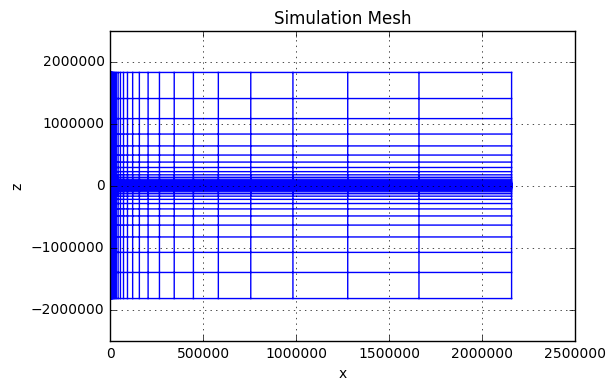

In [11]:
# X and Z limits we want to plot to. Try 
xlim = np.r_[0., 2.5e6]
zlim = np.r_[-2.5e6, 2.5e6]

fig, ax = plt.subplots(1,1)
mesh.plotGrid(ax=ax)

ax.set_title('Simulation Mesh')
ax.set_xlim(xlim)
ax.set_ylim(zlim)

## Put Model on Mesh

The electrical conductivity is defined at cell centers when using the finite volume method. 

In [12]:
sigma = sig_air*np.ones(mesh.nC)  # start with air cells
sigma[mesh.gridCC[:,2] < 0.] = sig_halfspace  # cells below the earth

# indices of the sphere
sphere_ind = (mesh.gridCC[:,0]**2 + (mesh.gridCC[:,2] - sphere_z)**2) <= sphere_radius**2 
sigma[sphere_ind] = sig_sphere  # sphere

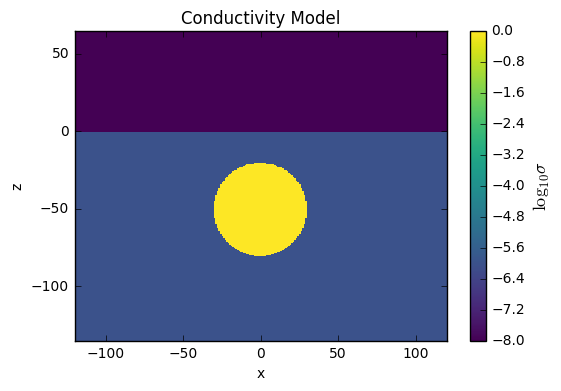

In [13]:
# Plot a cross section through the mesh
fig, ax = plt.subplots(1,1)
cb = plt.colorbar(mesh.plotImage(np.log10(sigma), ax=ax, mirror=True)[0])

# plot formatting and titles
cb.set_label('$\log_{10}\sigma$', fontsize=13)
ax.axis('equal')
ax.set_xlim([-120., 120.])
ax.set_ylim([-100., 30.])
ax.set_title('Conductivity Model')

## Set up the Survey

Define sources and receivers. For this example, the receivers are magnetic flux recievers, and are only looking at the secondary field (eg. if a bucking coil were used to cancel the primary). The source is a vertical magnetic dipole with unit moment. 

In [14]:
# Define the receivers
bx_r = FDEM.Rx.Point_bSecondary(locs=rx_loc, orientation='z', component='real')
bx_i = FDEM.Rx.Point_b(locs=rx_loc, orientation='z', component='imag')

rxList = [bx_r, bx_i]

In [15]:
srcList = [FDEM.Src.MagDipole(rxList, f, src_loc, orientation='z') for f in freqs]

## Set up Forward Simulation 

A forward simulation consists of a paired SimPEG problem and Survey. For this example, we use the E-formulation of Maxwell's equations, solving the second-order system for the electric field, which is defined on the cell edges of the mesh. 

In [16]:
prob = FDEM.Problem3D_e(mesh, sigmaMap=Maps.IdentityMap(mesh))
prob.solver = Solver
survey = FDEM.Survey(srcList)

prob.pair(survey)

In [17]:
%%time
fields = prob.fields(sigma)

CPU times: user 13.2 s, sys: 1.19 s, total: 14.4 s
Wall time: 7.98 s


### Take the ratio with the primary field

If simulating a DIGHEM survey, for example, the data are provided as the ratio of the secondary field with the primary as measured at the receiver in free space. 

In what follows, we set calculate the primary field at the receiver, calcuate the secondary magnetic fields measured by the receiver (**dpred**) and then take the ratio with the primary. 

In [18]:
# Primary Field at receiver
rx = rxList[0]
P = rx.getP(mesh, 'Fz')
bprimary = fields[srcList[1], 'bPrimary']
b0 = P*bprimary
b0 = b0[0][0].real

In [19]:
dpred = survey.dpred(sigma, f=fields)

In [20]:
# reshape the data vector by sources and receivers
dpred_reshaped = dpred.reshape((len(rxList), len(srcList)), order='F').T
dpred_real = dpred_reshaped[:,0]
dpred_imag = dpred_reshaped[:,1]

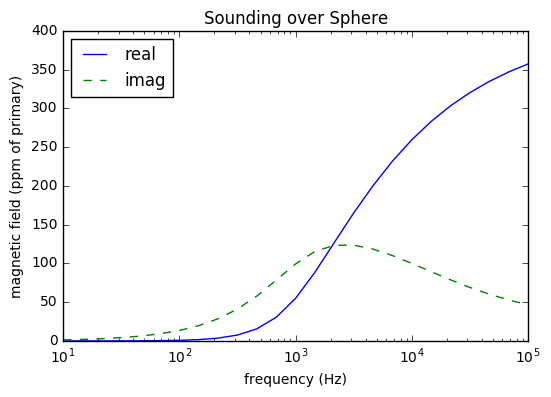

In [31]:
# Plot
fig, ax = plt.subplots(1,1)

ax.semilogx(freqs, dpred_real/b0*1e6)
ax.semilogx(freqs, dpred_imag/b0*1e6,'--')

ax.legend(['real','imag'], loc='best')
ax.set_title('Sounding over Sphere')
ax.set_ylabel('magnetic field (ppm of primary)')
ax.set_xlabel('frequency (Hz)')